# Capstone Project
### Exploratory Analysis of Single Cell RNA-seq Data for cell type annotation
##### Lexius Lynch, Masters in Data Science, Meharry Medical College. USA.
##### Advisor: Bishnu Sarker, Assistant Professor of Computer Science and Data Science, Meharry Medical College, USA.

Problem statement: Given a single RNA-Seq gene expression matrix, the purpose is to perform a comprehensive exploratory data analysis with following objectives:
1. Clustering the cells into distinct groups.
2. Identifying differentially expressed genes in each clusters
3. Using marker genes to annotate the cell types.

Following tutorial adopted from https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html provides the basis of the analysis intented in the capstone.

A gene is a chain of nucleotides in DNA or RNA


#### Dataset: 
#### Single-cell RNA sequencing of peripheral blood reveals immune cell signatures in Alzheimer's disease

#### Preparing the environtment
Two python packages initially need to be installed:
1. `pip install leidenalg`
2. `pip install scanpy`


The leidenalg package facilitates community detection of networks and builds on the package igraph.


Scanpy includes preprocessing, visualization, clustering, trajectory inference and differential expression testing

In [1]:
!pip install leidenalg
!pip install scanpy

In [2]:
!pip install scvelo #analysis in single cell RNA

In [3]:
pip install scikit-learn #predicitive data analysis 

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [5]:
# import packages
import leidenalg
import scanpy as sc
import pandas as pd
import anndata as ad
#######
import matplotlib.pyplot as pl 
import igraph
import loompy as lmp # to store single-cell gene expression data:
from anndata import AnnData
from scipy import io # provides algorithms for optimization, differential equations, statistics 
from scipy.sparse import coo_matrix, csr_matrix
import os #provides functions for interacting with the operating system

In [6]:
import sklearn # Simple and efficient tools for predictive data analysis

In [7]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.21.6 scipy==1.7.3 pandas==1.4.2 scikit-learn==1.4.2 statsmodels==0.13.2 igraph==0.11.4 pynndescent==0.5.11


In [8]:
results = "write/ADfinal.h5ad" # the file that will store the analysis results

In [9]:
adata=sc.read_10x_mtx('../lexius/AD_cellz/', var_names='gene_symbols', make_unique=True, 
                    cache=True, cache_compression=None, gex_only=True, prefix= 'GSE181279_')

... reading from cache file cache/..-lexius-AD_cellz-GSE181279_matrix.h5ad


/opt/anaconda3/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [10]:
adata

AnnData object with n_obs × n_vars = 36849 × 32738
    var: 'gene_ids', 'feature_types'

This was the most challening portion. 


With reading the dataset into scanpy its very important for the anndata to be right. It took me a lot of time. The read function contains the pathway to the file. 

Anndata stores a data matrix with annotations of observations, variables, and unstructured annotations. So it is basically a dataframe.
I ran into issues with not being able to find the file in the directory. I had to add the prefix from the original file

#### Preprocessing
Show those genes that yield the highest fraction of counts in each single cell, across all cells.

normalizing counts per cell
    finished (0:00:00)


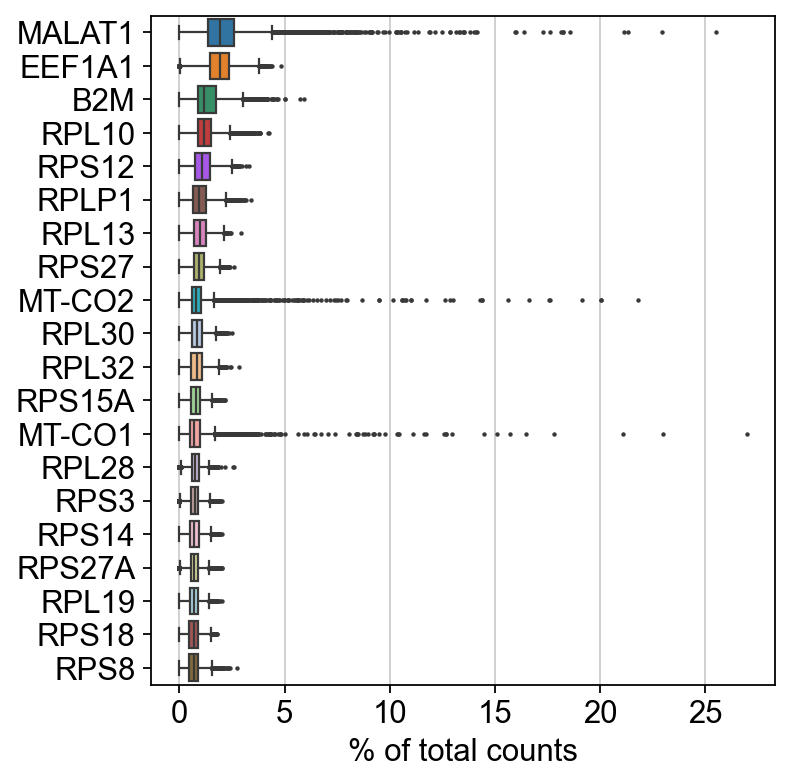

In [11]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [12]:
import matplotlib.pyplot as plt
import numpy as np

In [13]:
#create a pie graph to show the before and after of the cleaned data 

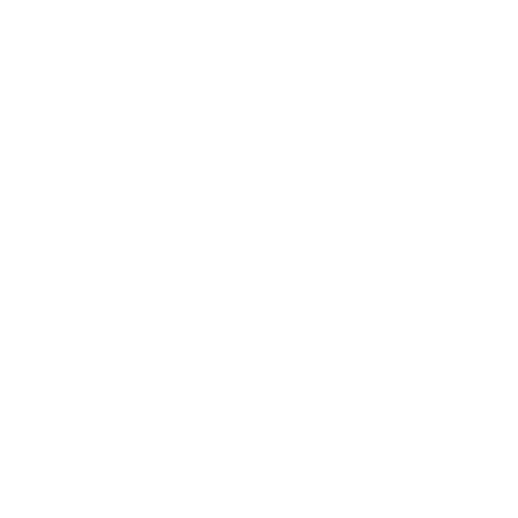

In [14]:
y = np.array([])

plt.pie(y)
plt.show() 

##### Highest fraction of cells
MALAT1
EEF1A1
B2M
RPL10
RPS12
RPLP1
RPL13
RPS27
MT-CO2
RPL30
RPL32
RPS15A
MT-CO1
RPL28
RPS3
RPS14
RPS27A
RPL19
RPS18
RPS8

In [15]:
# Basic filtering:

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19 cells that have less than 200 genes expressed
filtered out 13849 genes that are detected in less than 3 cells


In [16]:
#information about mitochondrial genes, which are important for quality control.

# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

A violin plot of some of the computed quality measures:

the number of genes expressed in the count matrix

the total counts per cell

the percentage of counts in mitochondrial genes

Gather information about mitochondrial genes by annotating them. Then removing  cells that have too many mt genes. 
Mitochondrial genes within cells indicate poor quality cells, due to them being larger
Also removed cells that have too many total counts


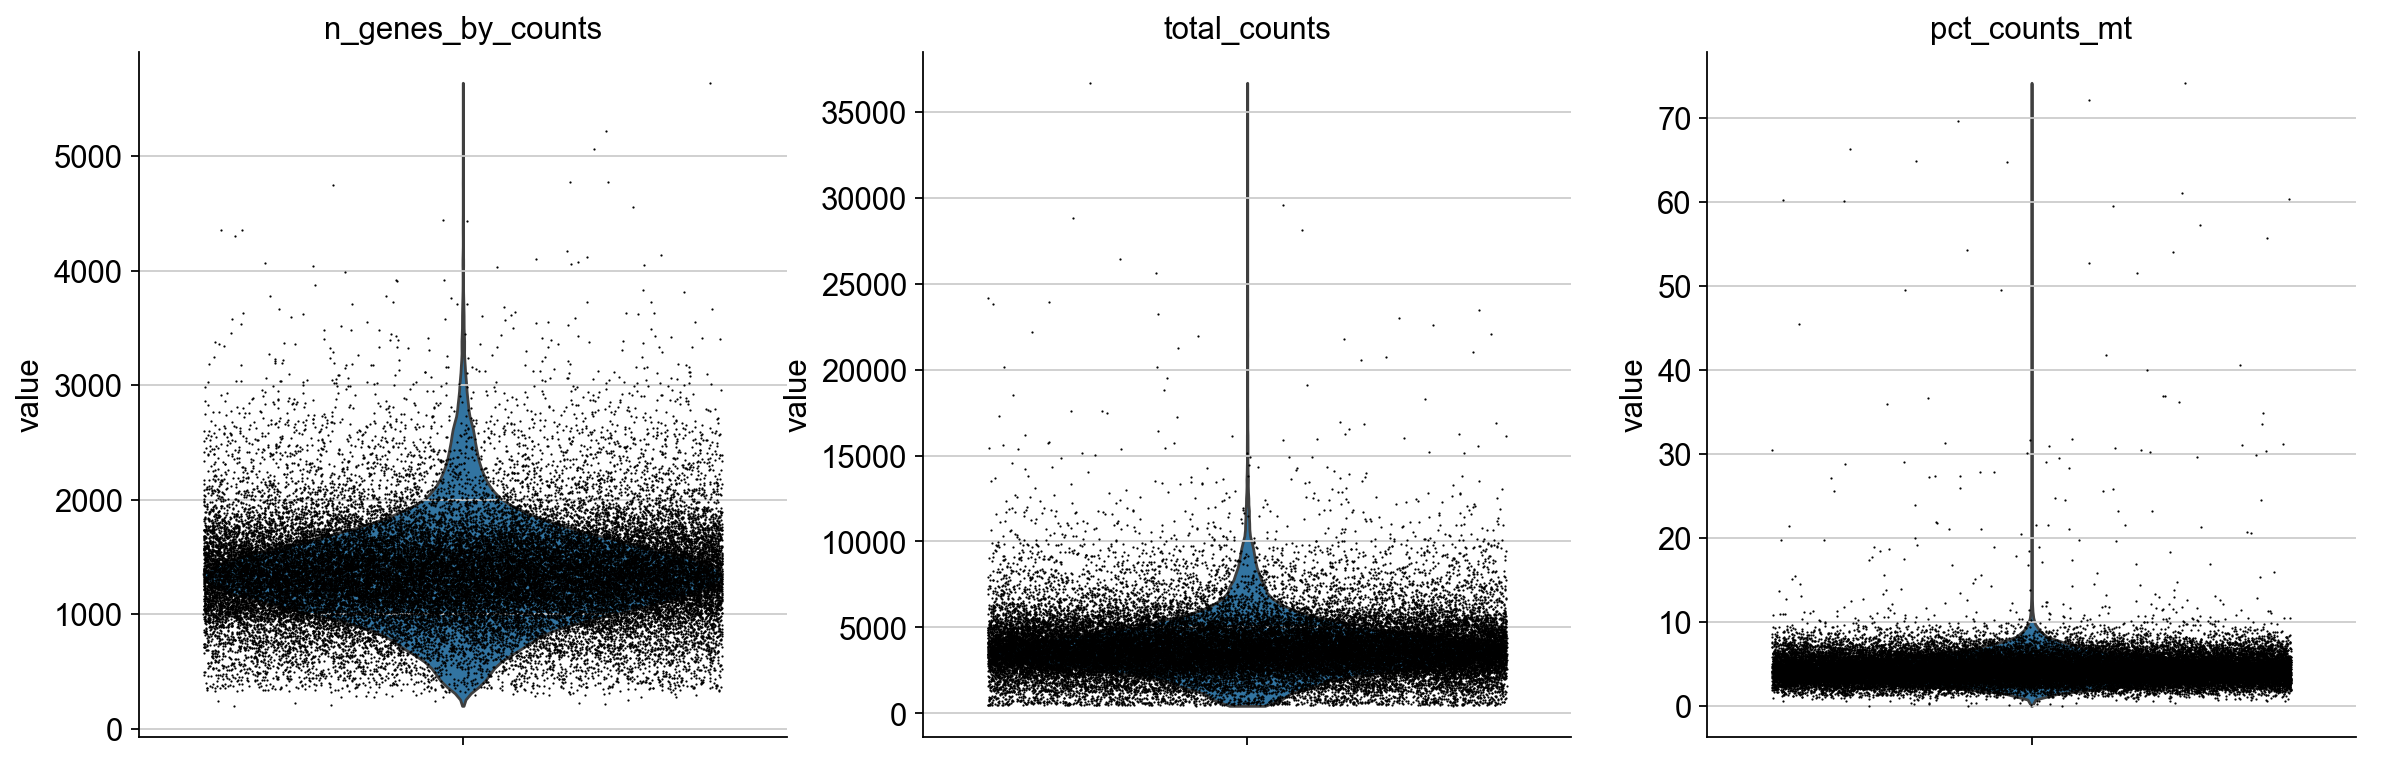

In [17]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

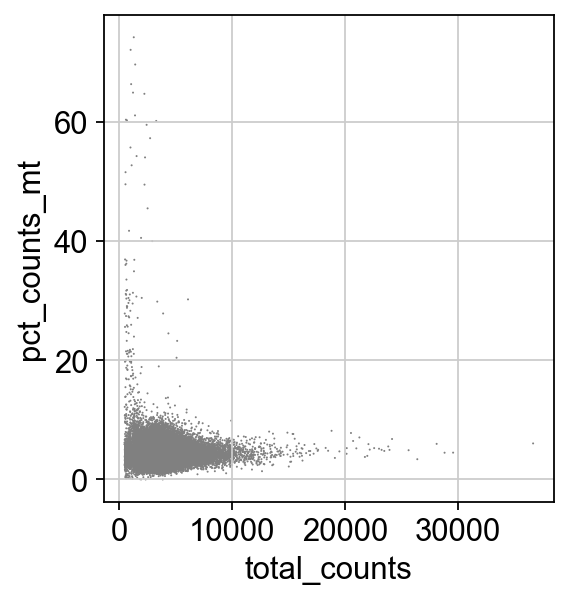

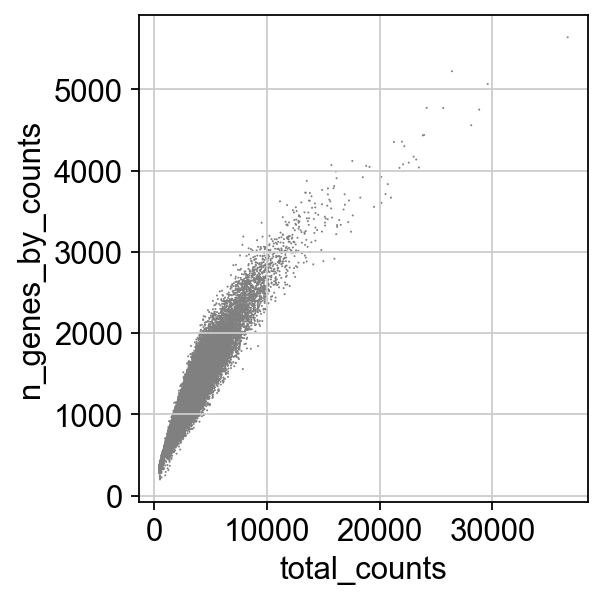

In [18]:
# Remove cells that have too many mitochondrial genes expressed or too many total counts:

sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

The purpose of slicing the anndata is to remove the cell counts that we dont need. 

Reads per cell = the total number of sequenced reads divided by the number of cells. 

Cells need to be normalized in order for them to be comparable


In [19]:
#slice the anndata 
adata = adata[adata.obs.n_genes_by_counts < 3000, :] #is less than 25000
adata = adata[adata.obs.pct_counts_mt < 20, :].copy() #is less than 5
# Total-count normalize (library-size correct) the data matrix to 10,000 reads per cell,
# so that counts become comparable among cells
sc.pp.normalize_total(adata, target_sum=1e4)


normalizing counts per cell
    finished (0:00:00)


The purpose of logarithmic function is to reduce skewness of a variable. This help with comparing the groups in the end.(remove outliers)


In [20]:
# Logarithmize the data:
sc.pp.log1p(adata)


extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


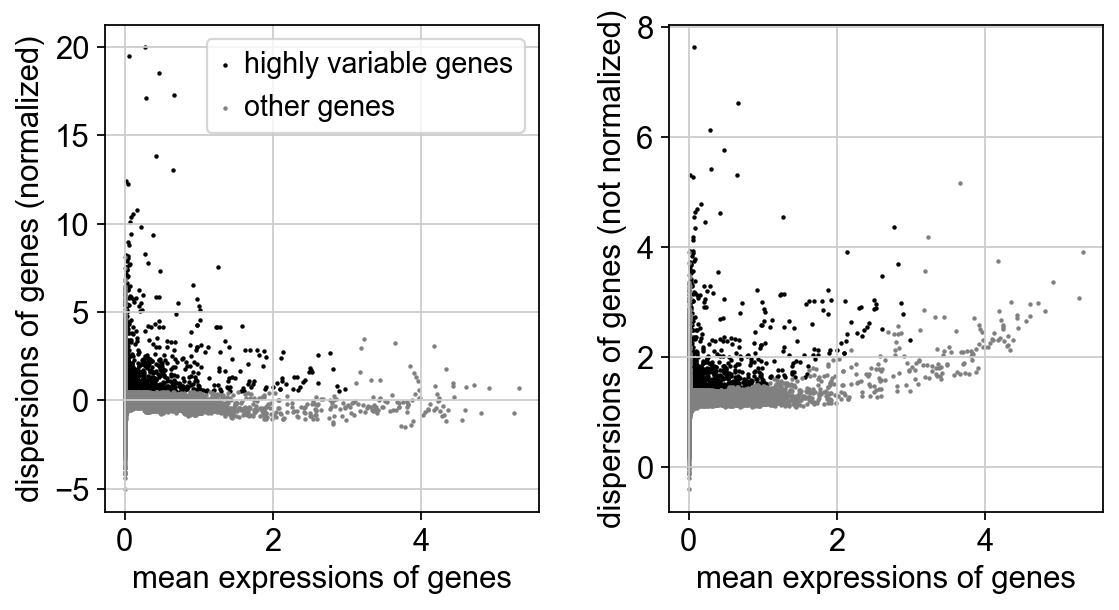

In [21]:
# Identify highly-variable genes. 
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

sc.pl.highly_variable_genes(adata)


In [22]:
adata.raw = adata

In [23]:
# filteirng
adata = adata[:, adata.var.highly_variable]

In [24]:
# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:50)


In [25]:
# Scale each gene to unit variance. Clip values exceeding standard deviation 10.

sc.pp.scale(adata, max_value=10)

### Principal component analysis
Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

"Contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function sc.tl.louvain() or tSNE sc.tl.tsne(). In our experience, often a rough estimate of the number of PCs does fine."

In [26]:
sc.tl.pca(adata, svd_solver="arpack")

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


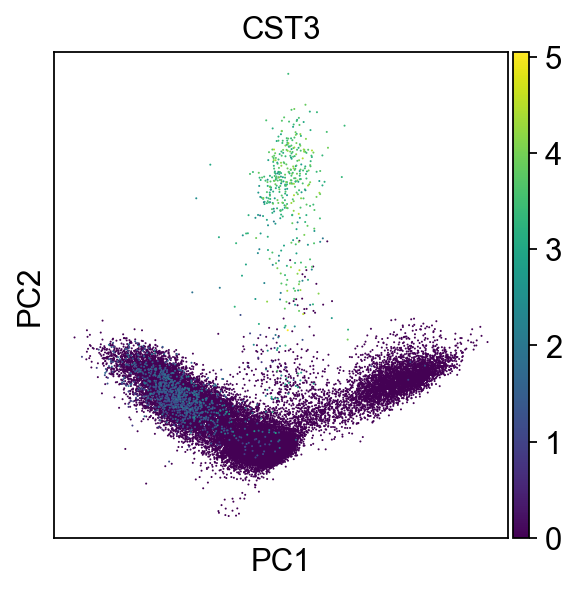

In [27]:
sc.pl.pca(adata, color="CST3")

Talk about first 30 varinace ratio : how man pc you need to use. 
Do more research about this section 
This is used to build the 

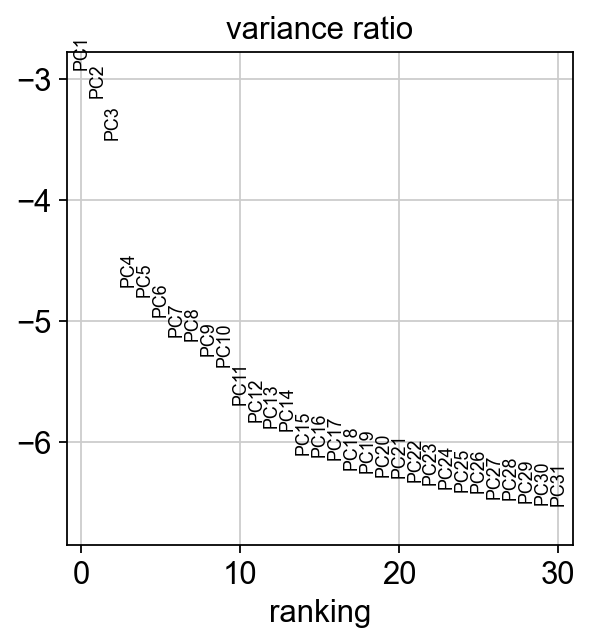

In [28]:
sc.pl.pca_variance_ratio(adata, log=True)


In [29]:
#adata.write(results_file)


In [30]:
adata # will show the annotations

AnnData object with n_obs × n_vars = 36548 × 1139
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighborhood graph ??



In [31]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40) #need more information 


computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)


## Embedding the neighborhood graph



sc.tl.leiden(adata)
sc.pl.paga(adata)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

In [41]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:17)


CST3 -blocking (inhibiting) the activity of certain enzymes 
NKG7 - expressed by CD4+ and CD8+ T cells
PPBP - protein coding gene (diseases: Erythromelalgia and Thrombocytosis)

https://medlineplus.gov/genetics/gene 
APP -amyloid precursor protein
sAPP - formation of neurons in the brain both before and after birth
(other names for this disease with amyloid) 
AAA 
ABETA
CVAP 
apolipoprotein E (APOE) gene -carry cholesterol and other types of fat in the bloodstream. contribute to AD

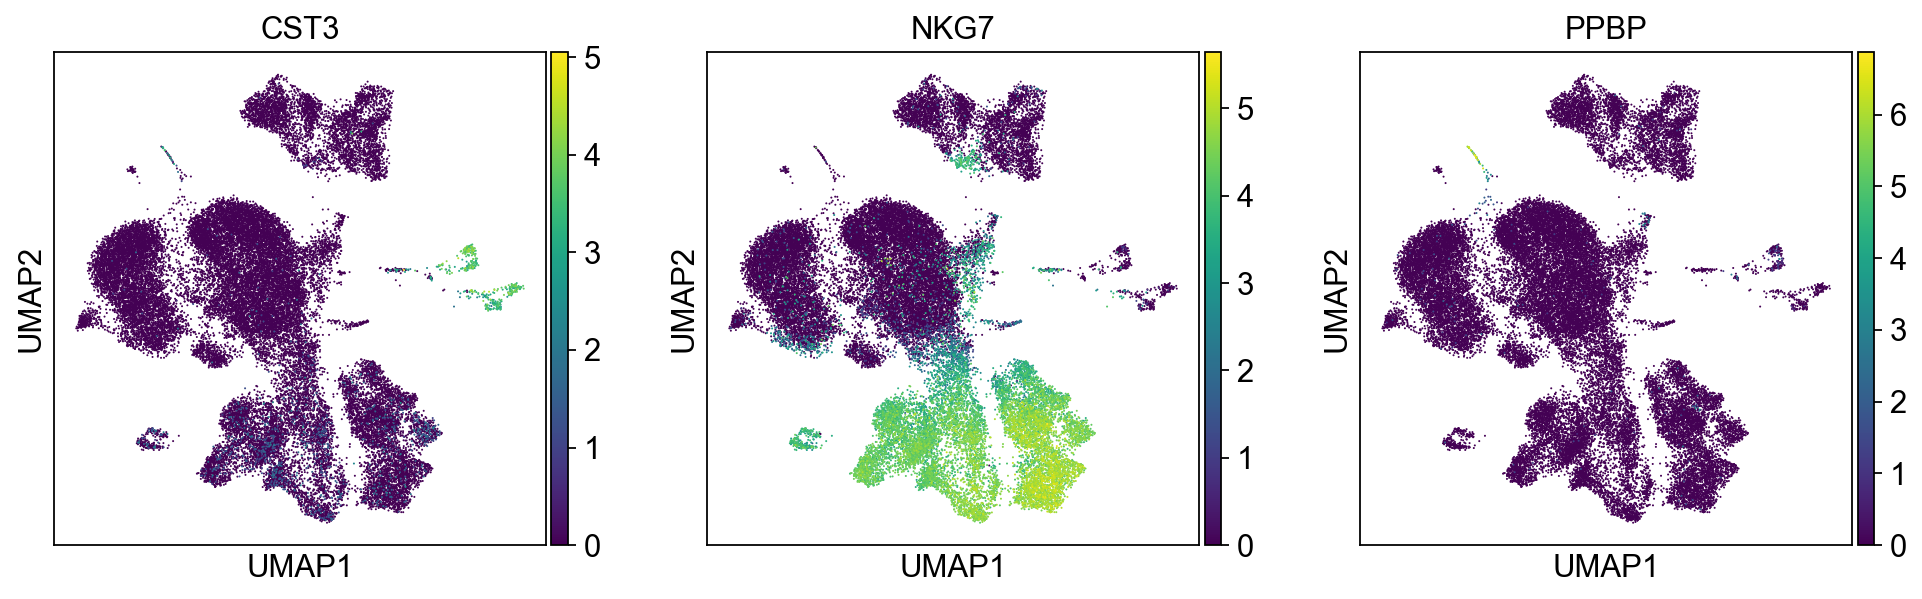

In [60]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"])
# these graphs show the raw normalized, logarithmized, but uncorrected gene expression  

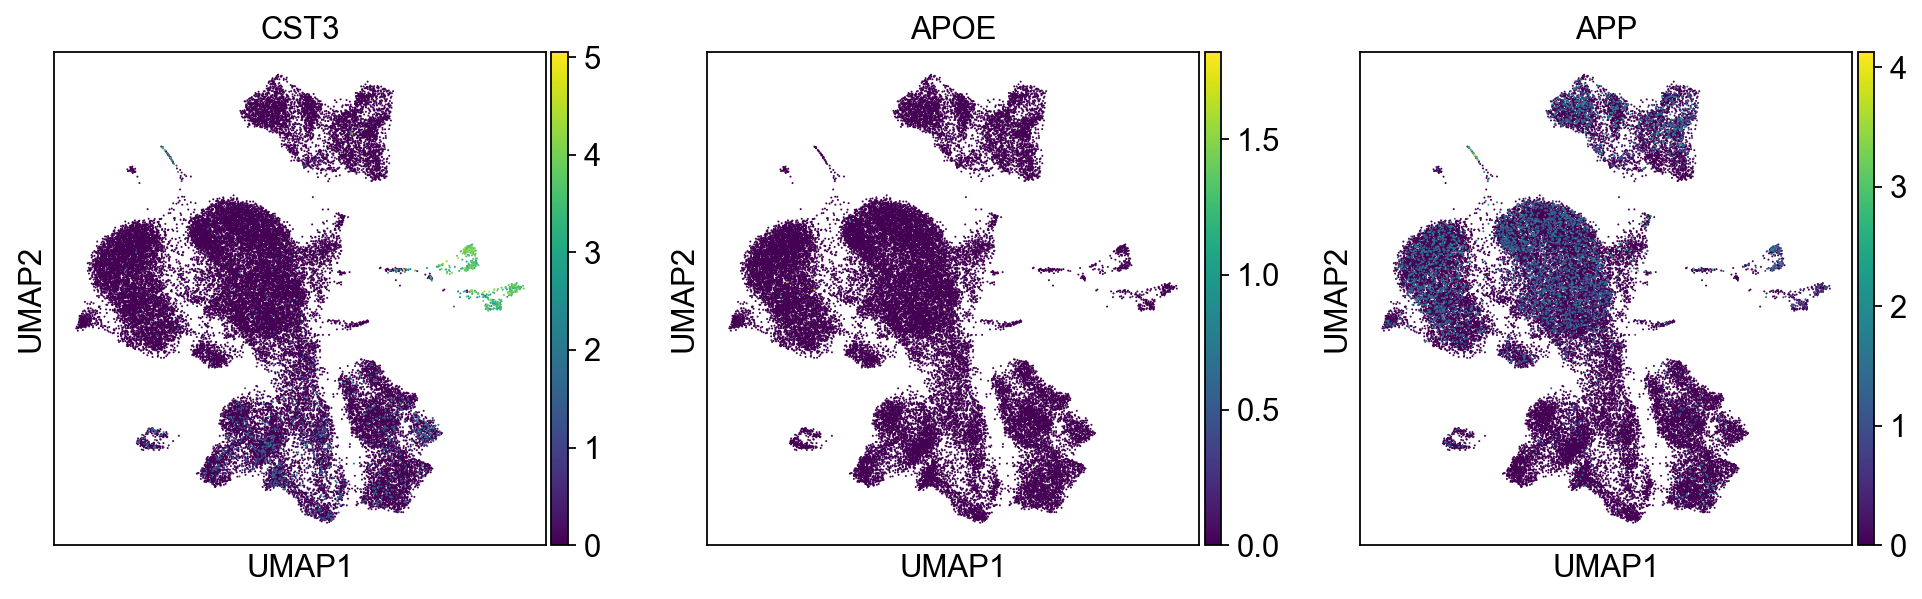

In [59]:
sc.pl.umap(adata, color=["CST3", "APOE", "APP"])


In [43]:
adata.var.index #use this to find if it has the gene NKG7 

Index(['ISG15', 'TNFRSF18', 'TNFRSF4', 'AL645728.1', 'PLCH2', 'ESPN', 'ERRFI1',
       'SPSB1', 'PLOD1', 'TNFRSF1B',
       ...
       'SLC37A1', 'SIK1', 'AIRE', 'ITGB2', 'COL6A2', 'DIP2A', 'S100B',
       'MT-ND6', 'KIR2DL2', 'KIR3DL2-1'],
      dtype='object', length=1139)

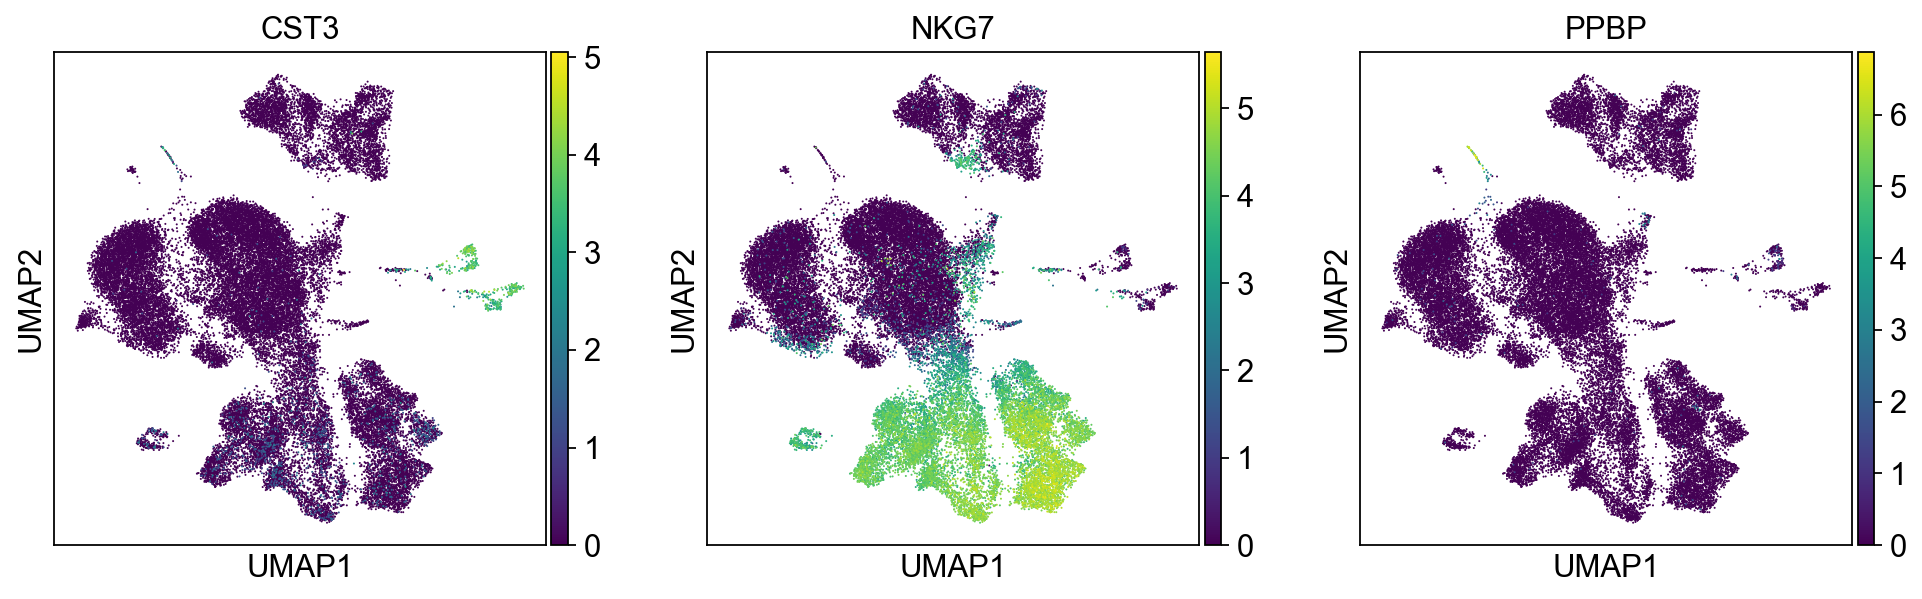

In [44]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"]) # I  took out use_raw=False 

### Top 20 genes after preprocessing. This will show you the top genes. But we have to remeber that all the genes were normalized and made the same. So comparing them in this view (boxplot) view would not be beneficial. 

normalizing counts per cell
    finished (0:00:00)


/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


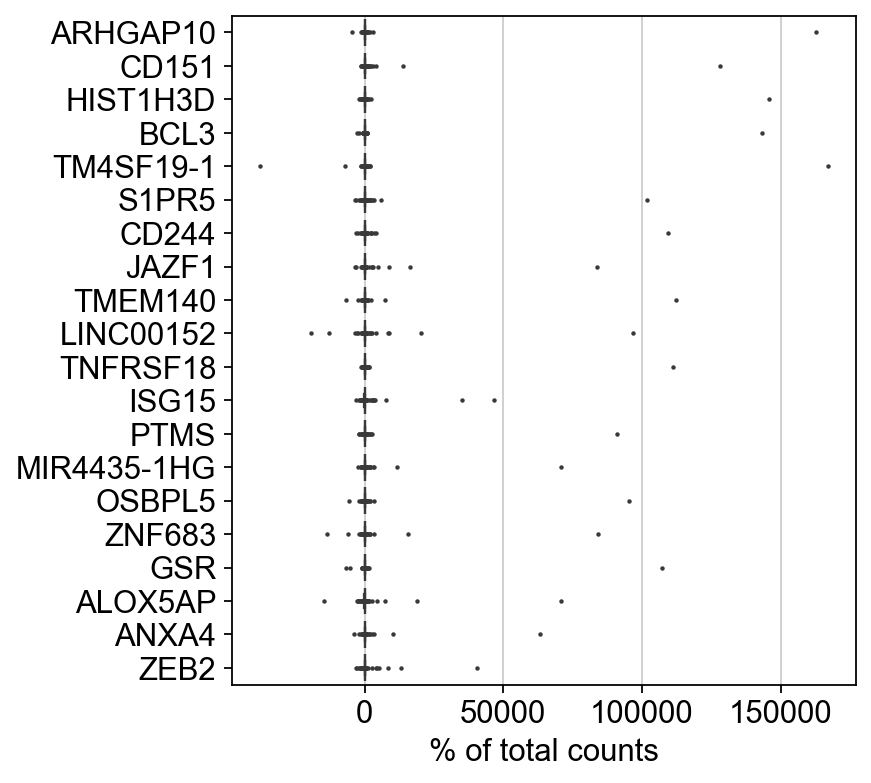

In [61]:

sc.pl.highest_expr_genes(adata, n_top=20) 

## Clustering the neighborhood graph 
Helps to cluster similar cells into appropriate groups , helps showcase patterns

In [45]:
sc.tl.leiden(
    adata,
    resolution=0.9,
    random_state=0,
    
    n_iterations=2,
    directed=False,
)

# removed flavor="igraph"

running Leiden clustering
    finished: found 23 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:04)


/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


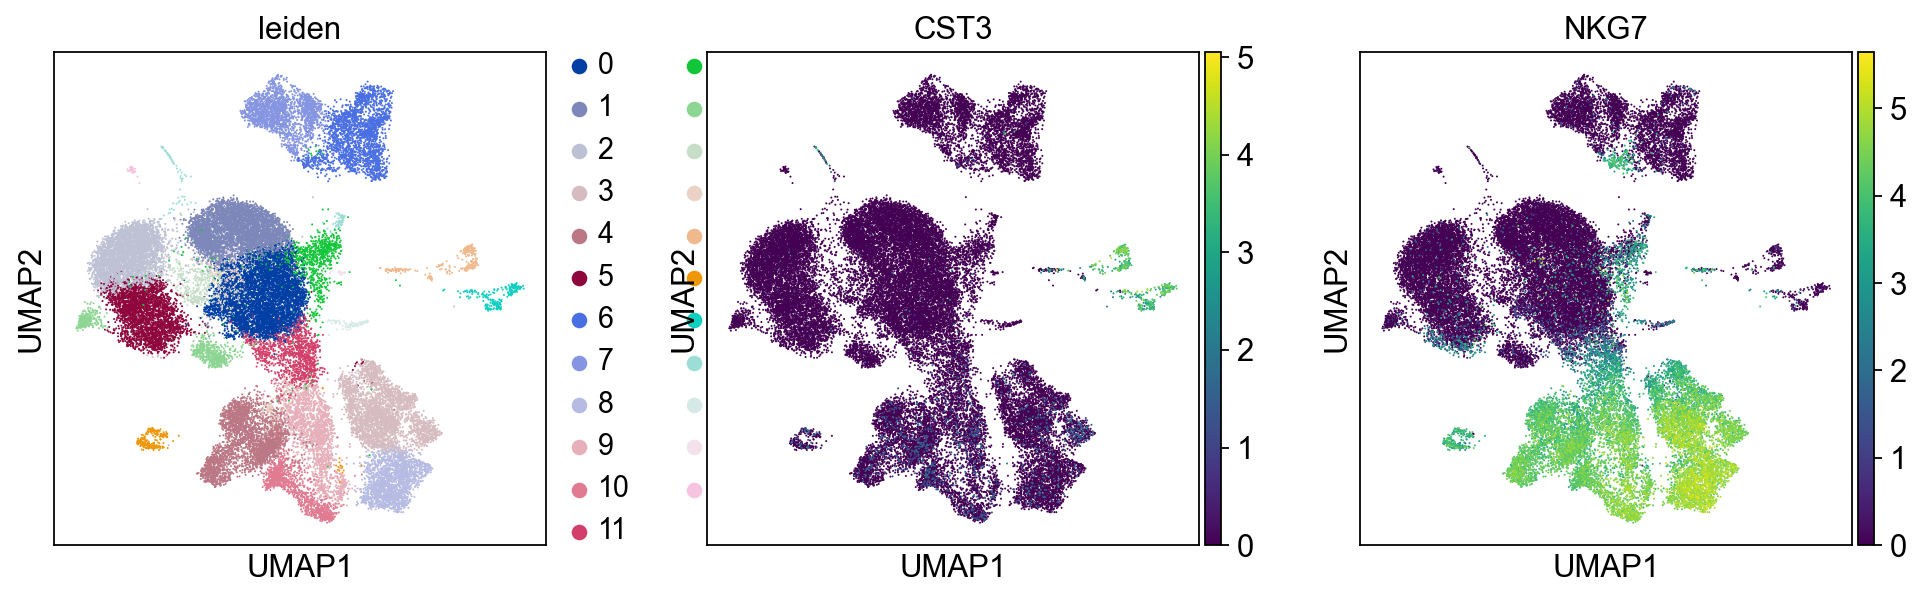

In [46]:
sc.pl.umap(adata, color=["leiden", "CST3", "NKG7"])


In [62]:
#adata.write(results_file)


## Finding marker genes ???

APOE-e4 
APOE-e2 
APOE-e3
Presenilin-1 (PS-1),(PS-2) 
Genes that increase the risk of Alzheimer's 

Need to Discuss further 

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:10)


/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning: DataFrame is highly fragmented.  This is usually t

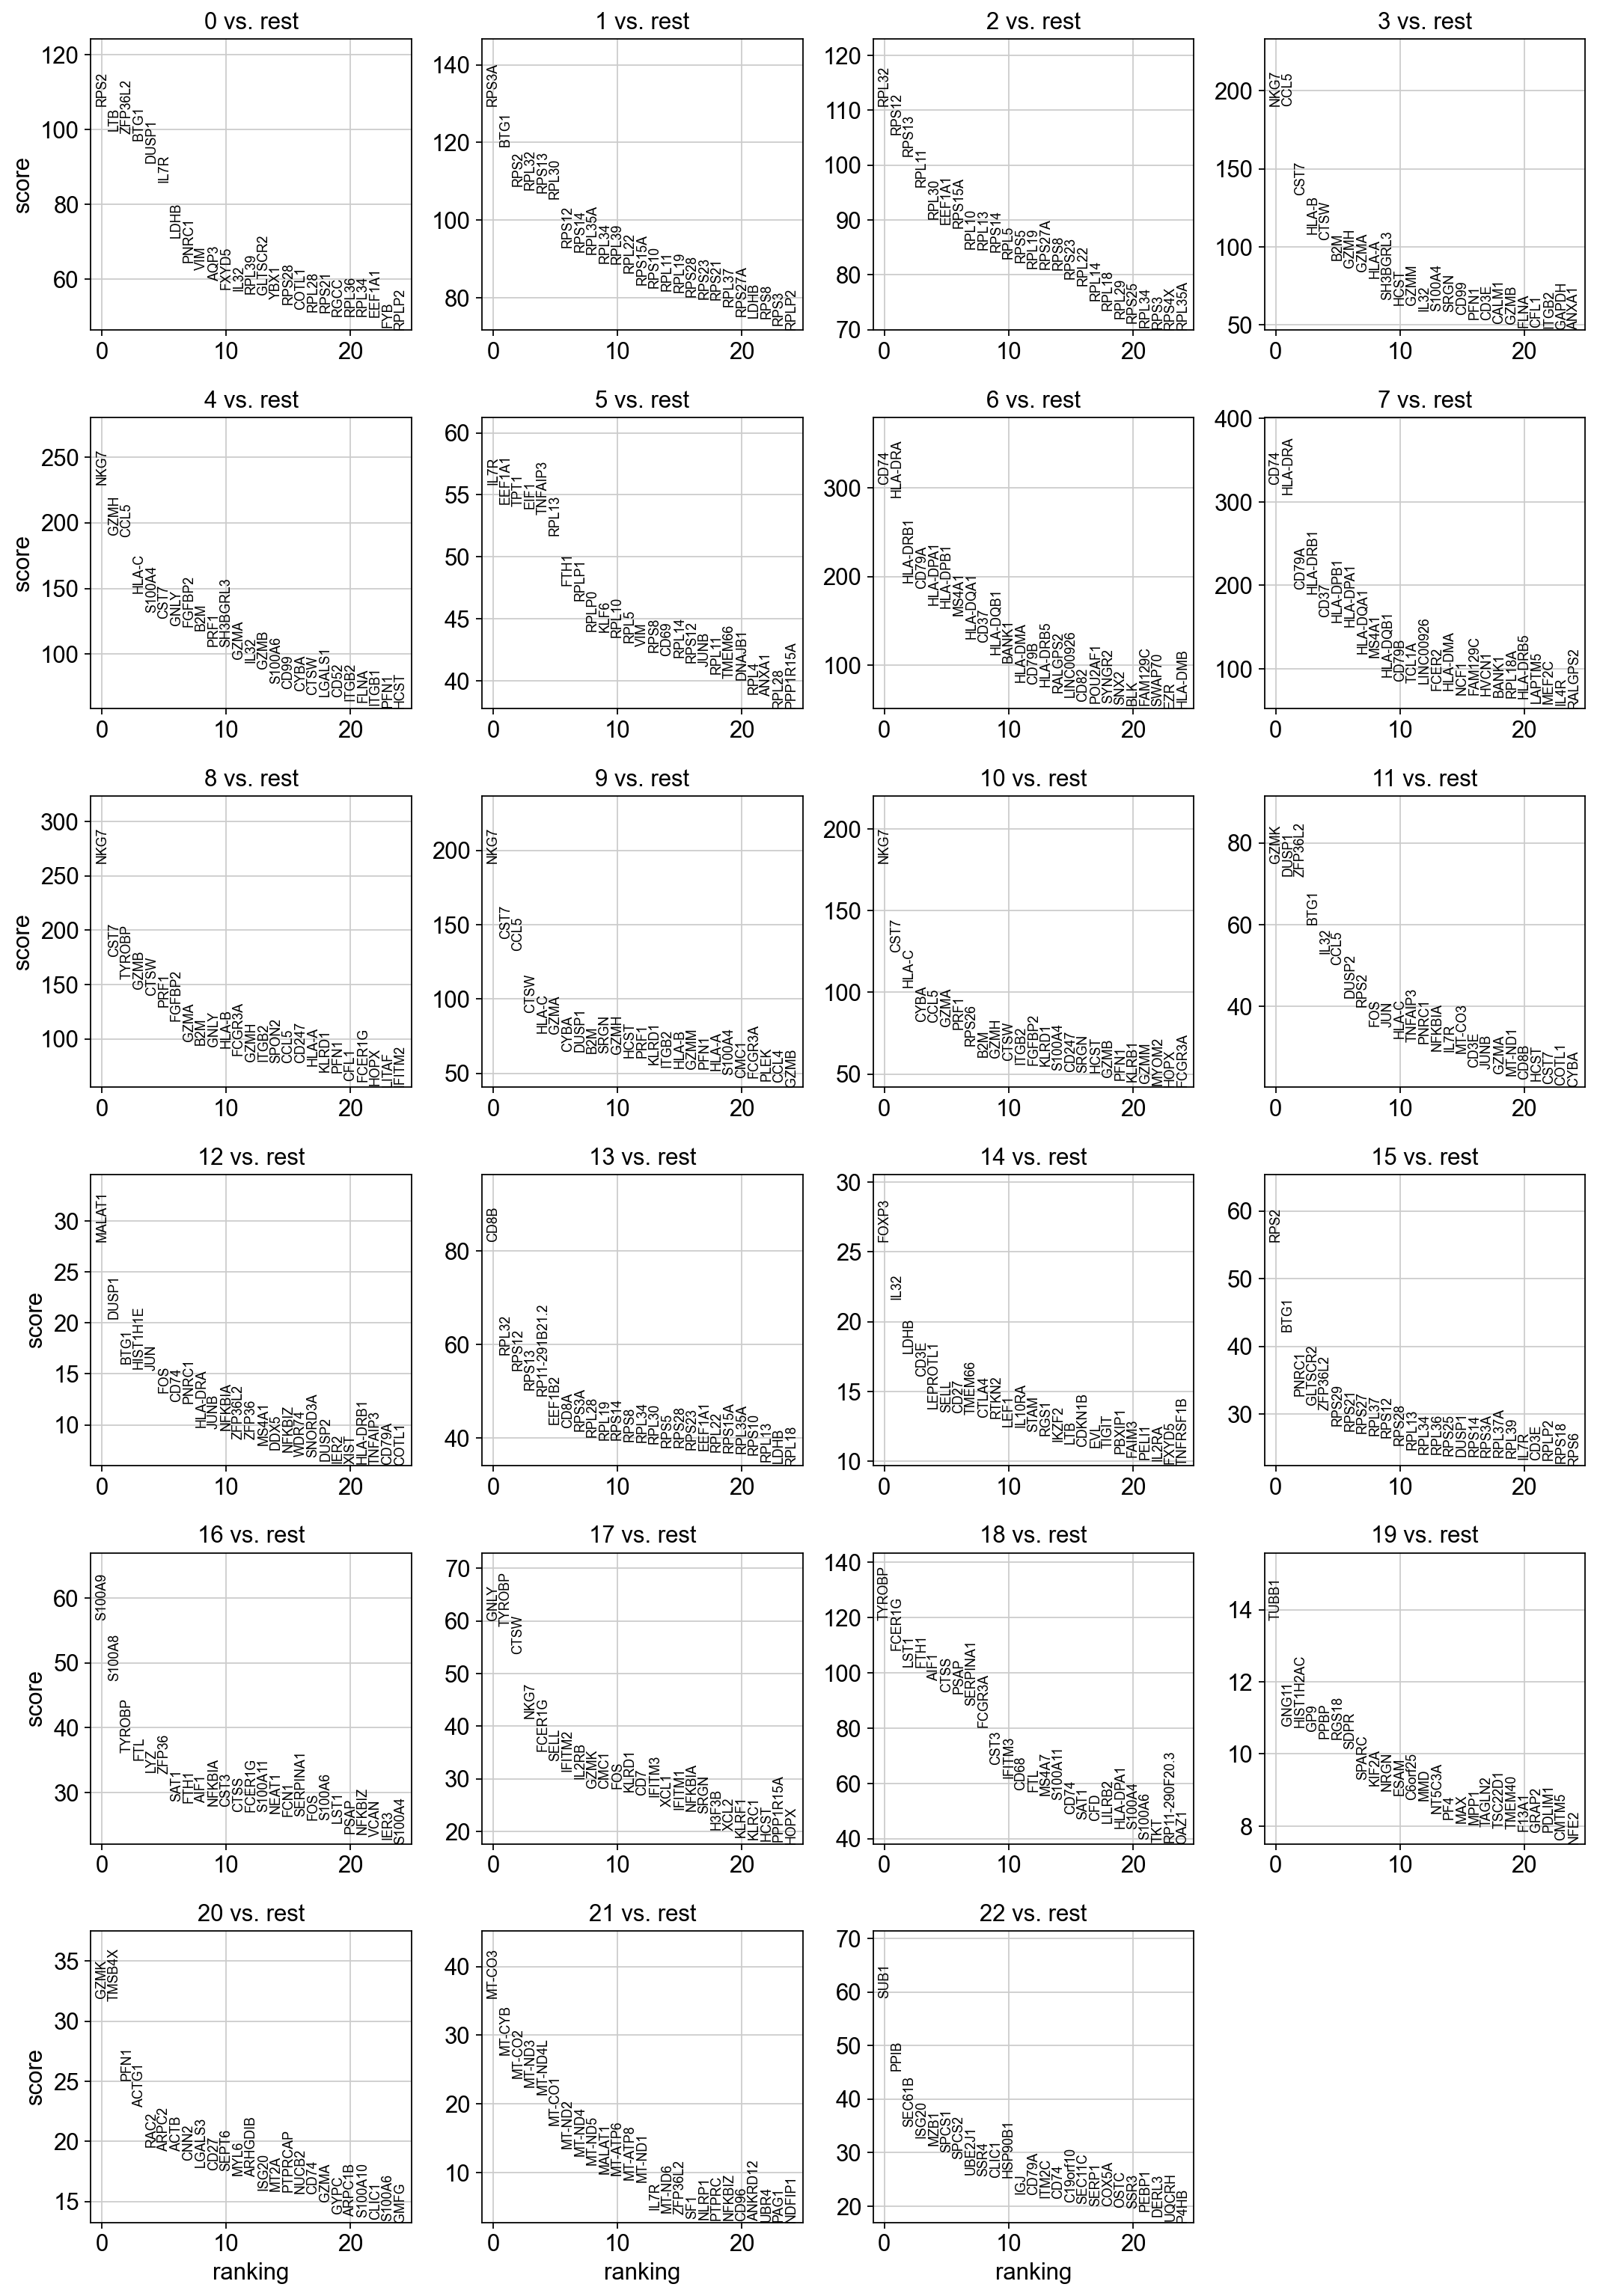

In [63]:
sc.tl.rank_genes_groups(adata, "leiden", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [64]:
sc.settings.verbosity = 2  # reduce the verbosity


ranking genes
    finished (0:00:44)


/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning: DataFrame is highly fragmented.  This is usually t

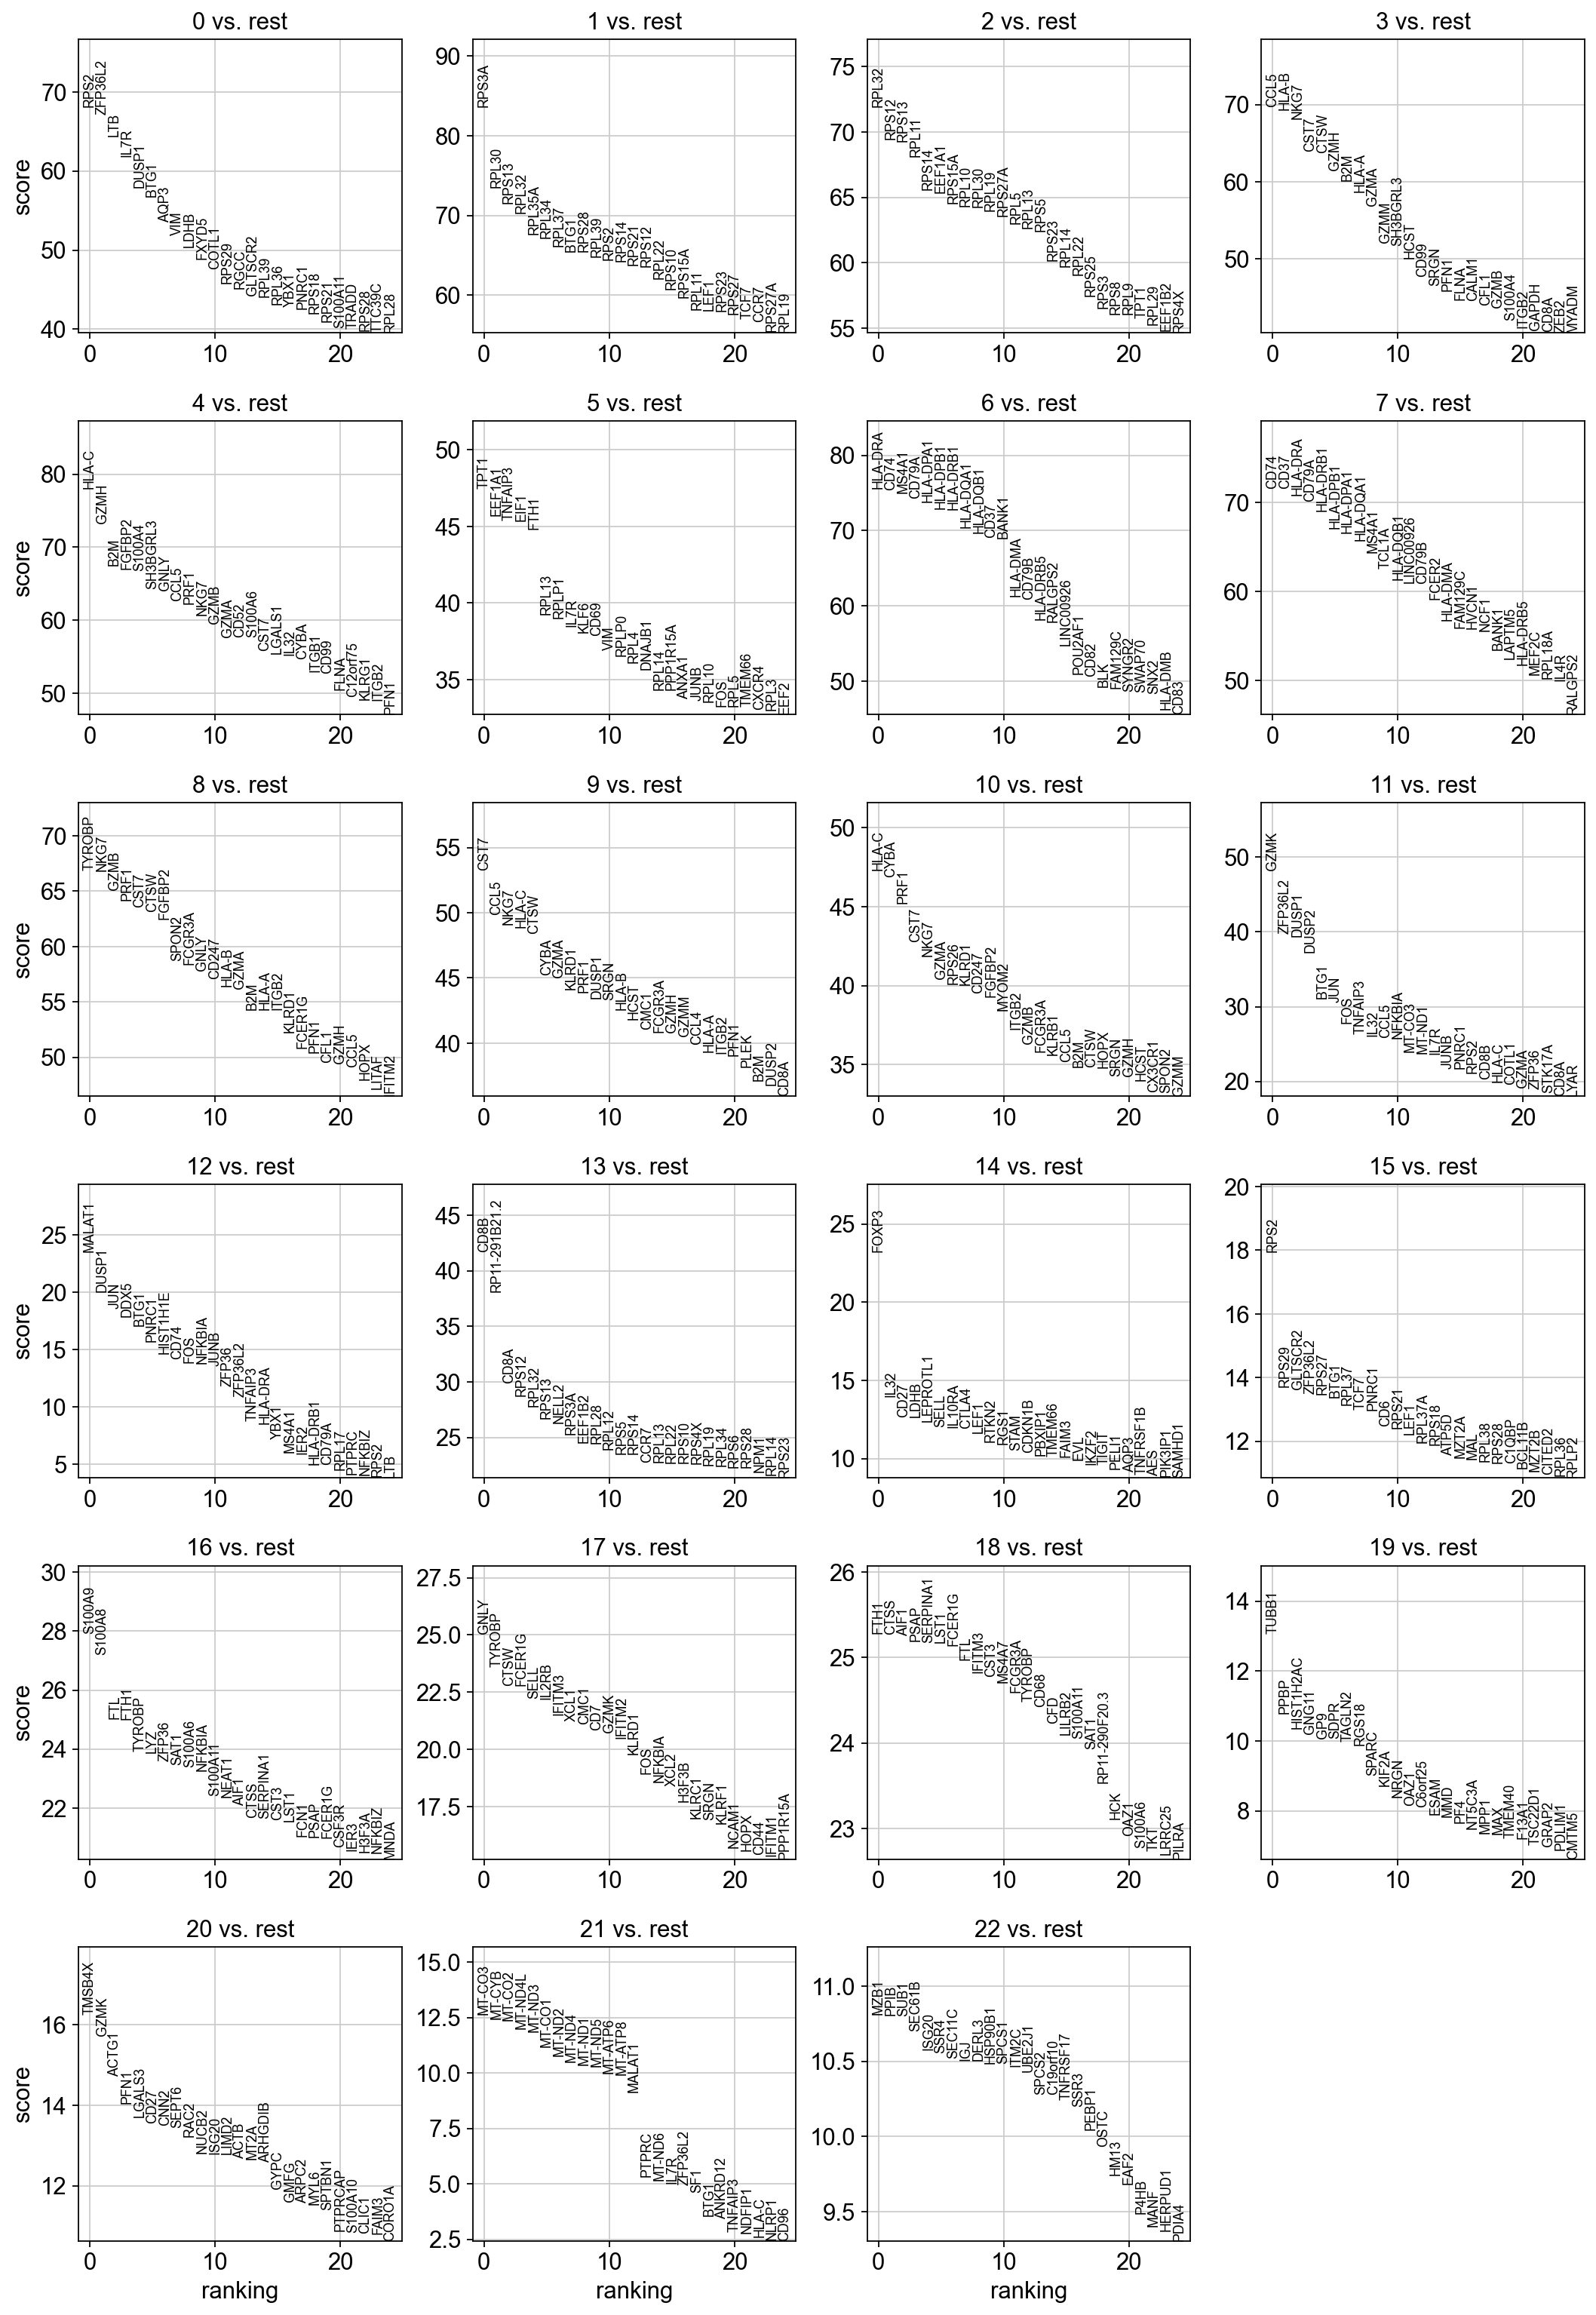

In [65]:
#ranking genes using wilcoxon 
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [67]:
#adata.write(results_file)

In [ ]:
#take first five genes, marker database, to know which cells contain these genes

#ranking genes using logistic regression  
sc.tl.rank_genes_groups(adata, "leiden", method="logreg", max_iter=1000)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
#define list of marker genes
marker_genes = [
    *["IL7R", "CD79A", "MS4A1", "CD8A", "CD8B", "LYZ", "CD14"],
    *["LGALS3", "S100A8", "GNLY", "NKG7", "KLRB1"],
    *["FCGR3A", "MS4A7", "FCER1A", "CST3", "PPBP"],
]

In [107]:
marker_genes = [
    *["RPS2", "RPS3A", "RPL32","NKG7", "CCL5", "HLA-C", "TPT1"],
    *["CD74", "HLA-DRA", "TYROBP", "CST7", "HLA-C", "GZMK", "MALAT1"],
    *["CD8B", "FOXP3","RPS2","S100A9","GNLY","FTH1","TUBB1", "TMSB4X","MT-CO3", "MZB1" ],
]

In [86]:
#adata = sc.read(results_file)


In [98]:
# Show the 20 top ranked genes per cluster 0, 1, …, 7 in a dataframe.


pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(20)

0
0     S100A4
1      AHNAK
2   SH3BGRL3
3      CRIP1
4       KLF6
5        FOS
6        B2M
7    S100A11
8      ITGB1
9      DUSP1
10     ANXA1
11   TNFAIP3
12       VIM
13   S100A10
14      IL32
15  PPP1R15A
16      FTH1
17      PFN1
18    S100A6
19     ZFP36

In [99]:
# Get a table with the scores and groups.


result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "scores"]
    }
).head(5) #replaced pvals with scores 

0_n        0_s
0    S100A4  61.957642
1     AHNAK  59.533089
2  SH3BGRL3  53.079224
3     CRIP1  52.778503
4      KLF6  50.796032

ranking genes
    finished (0:00:09)


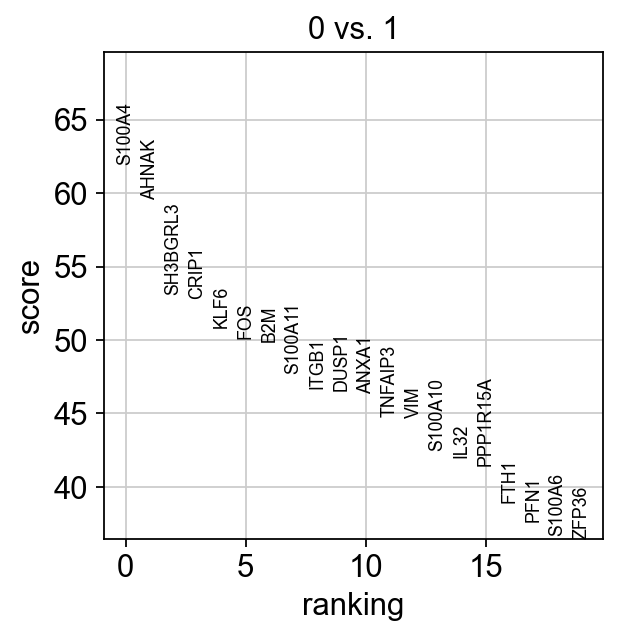

In [89]:
## very
# Compare to a single cluster:

sc.tl.rank_genes_groups(adata, "leiden", groups=["0"], reference="1", method="wilcoxon")
sc.pl.rank_genes_groups(adata, groups=["0"], n_genes=20)

/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/__init__.py:1170: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  _ax = sns.violinplot(
/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/__init__.py:1183: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  _ax = sns.stripplot(
/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/__init__.py:1199: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation='vertical')


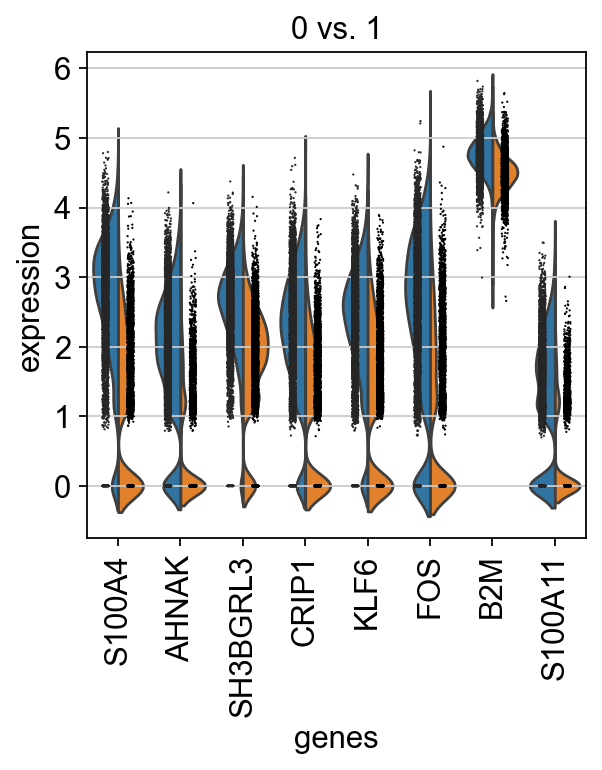

In [100]:
#more detailed view for a certain group
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)


In [91]:
#adata = sc.read(results_file)


/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/__init__.py:1170: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  _ax = sns.violinplot(
/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/__init__.py:1183: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  _ax = sns.stripplot(
/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/__init__.py:1199: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation='vertical')


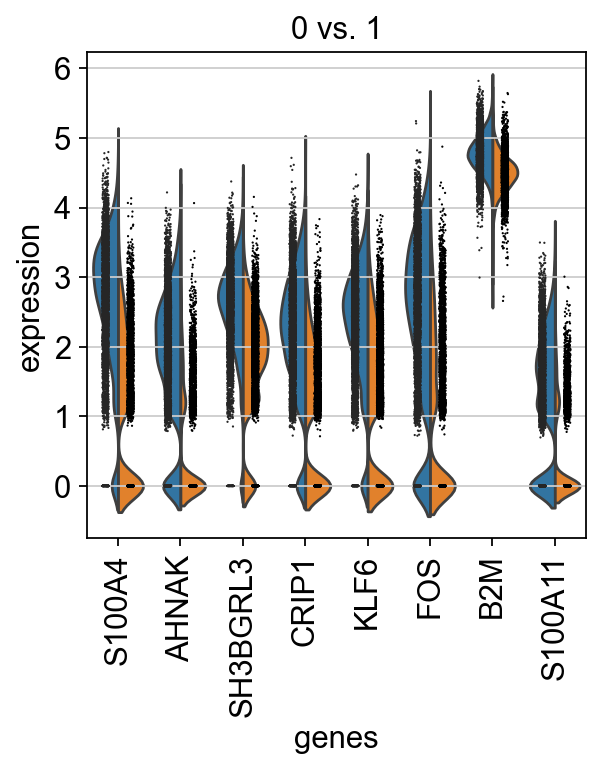

In [101]:
# Reload the object with the computed differential expression (a comparison with the rest of the groups)
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)


/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the 

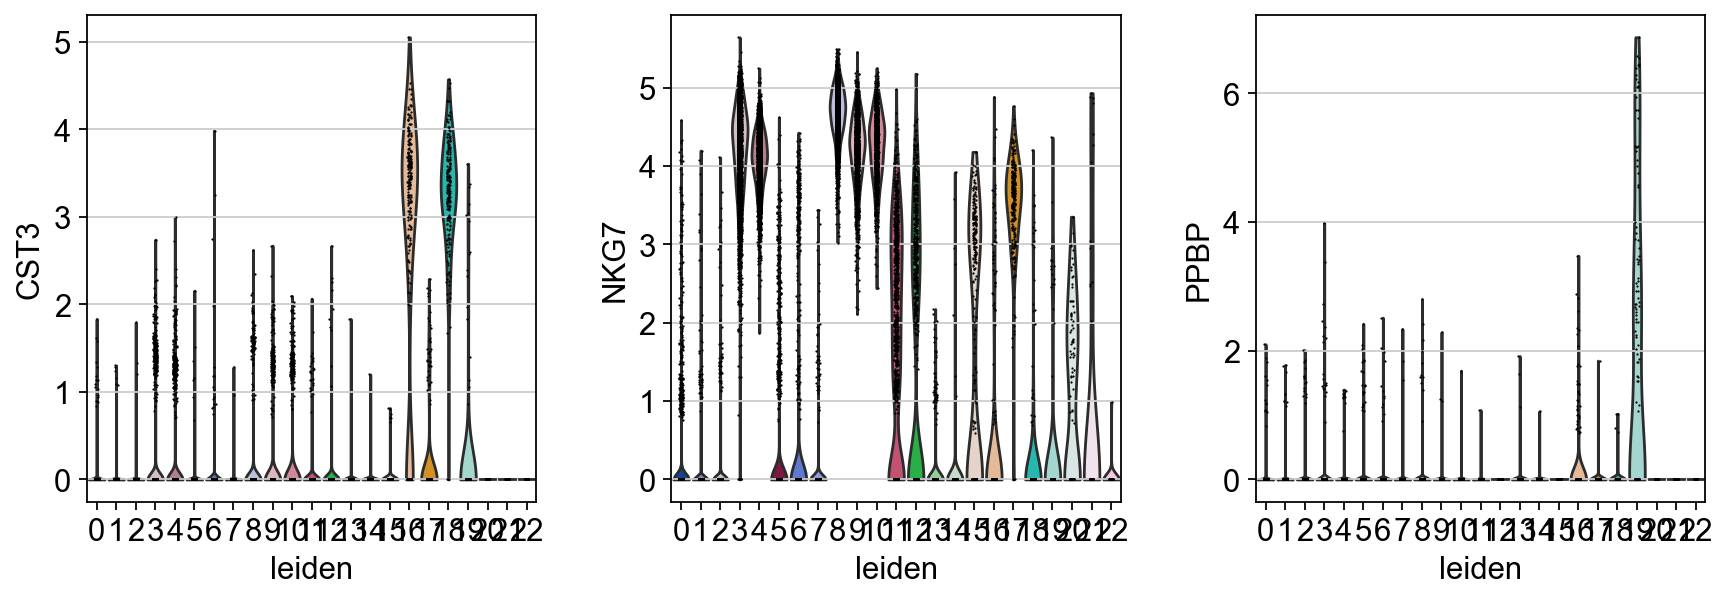

In [102]:
# To compare a certain gene across groups, use the following.

sc.pl.violin(adata, ["CST3", "NKG7", "PPBP"], groupby="leiden")


#mark the cell types
new_cluster_names = [
    "CD4 T",
    "B",
    "FCGR3A+ Monocytes",
    "NK",
    "CD8 T",
    "CD14+ Monocytes",
    "Dendritic",
    "Megakaryocytes",
]
adata.rename_categories("leiden", new_cluster_names) 

/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


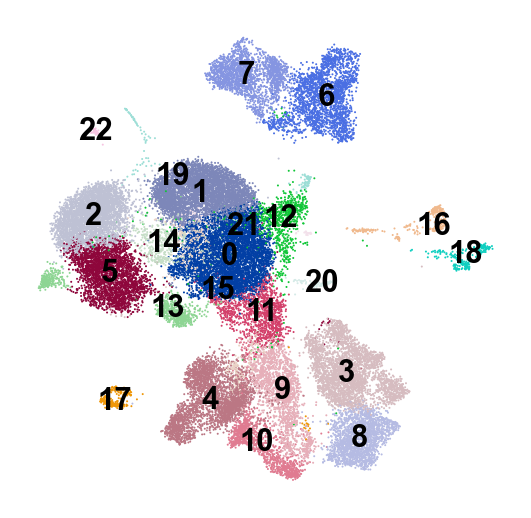

In [109]:
#cell annotation by cell types - there are more cell types than the ones from previous step
sc.pl.umap(
    adata, color="leiden", legend_loc="on data", title="", frameon=False, save=".pdf"
)

/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


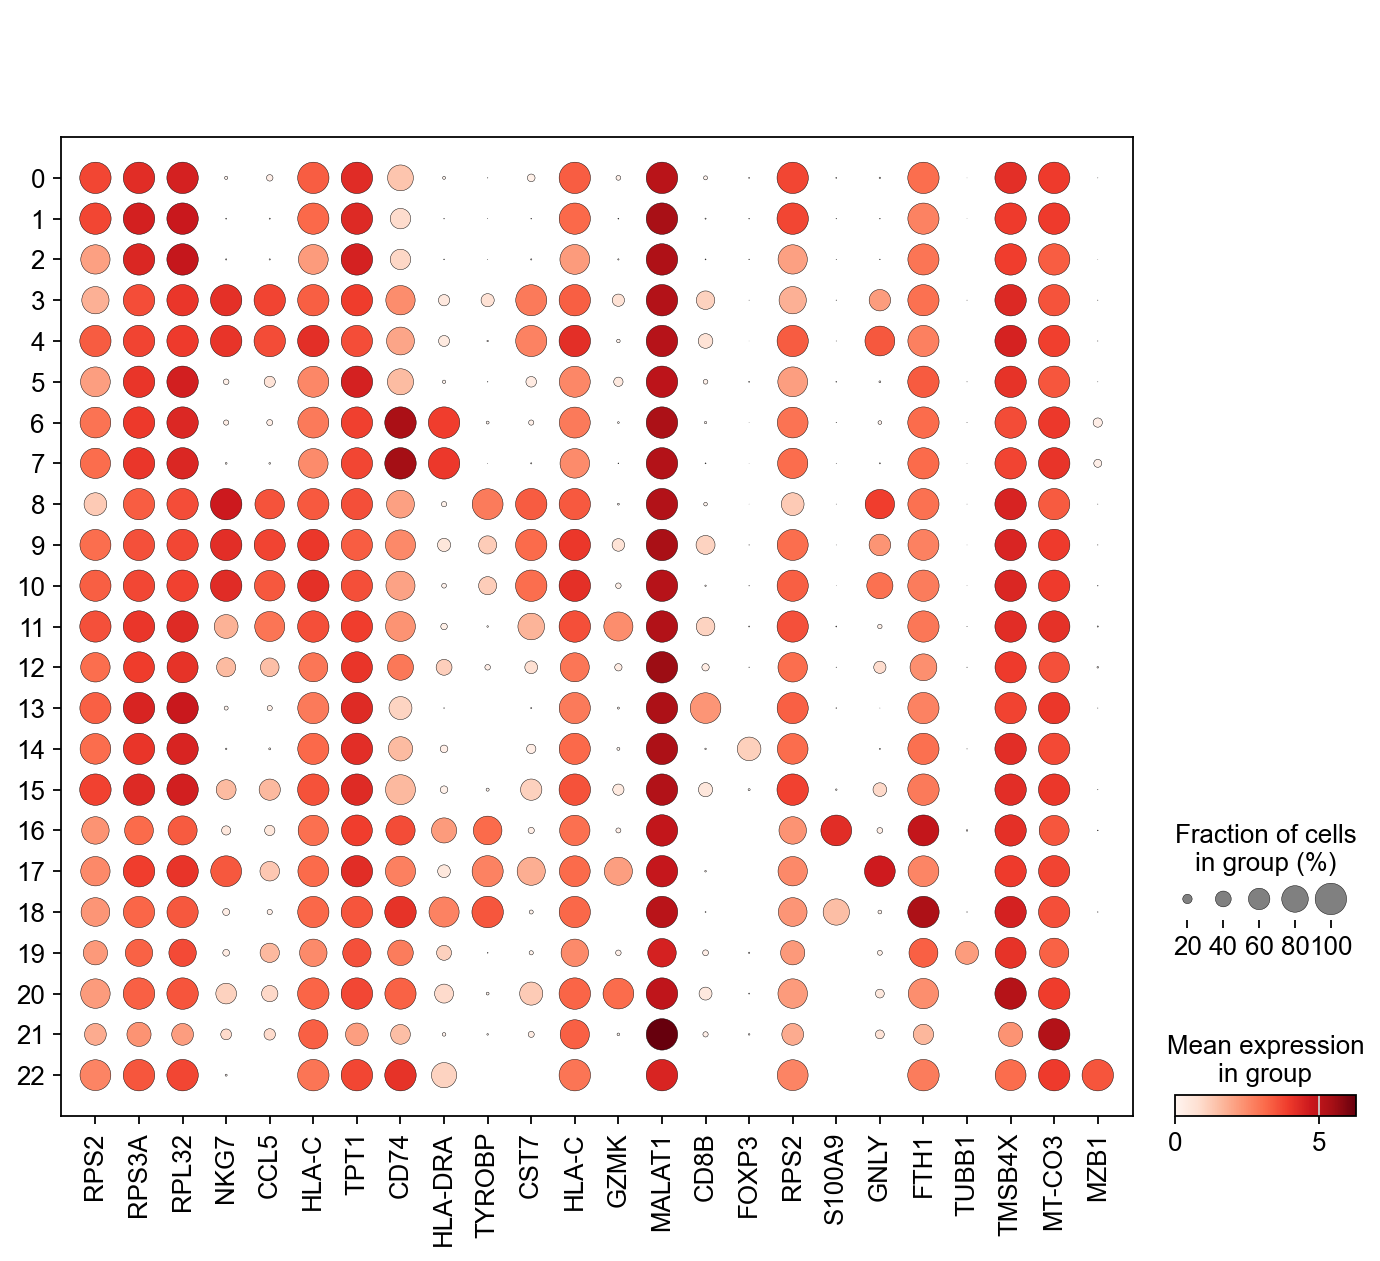

In [110]:
#visualize the marker cells
sc.pl.dotplot(adata, marker_genes, groupby="leiden");


In [ ]:
#compact violin 
sc.pl.stacked_violin(adata, marker_genes, groupby="leiden");


In [54]:
#create pie graph for cells before AnnData object with n_obs × n_vars = 36849 × 32738 genes Before
# 36548 × 1139 genes 

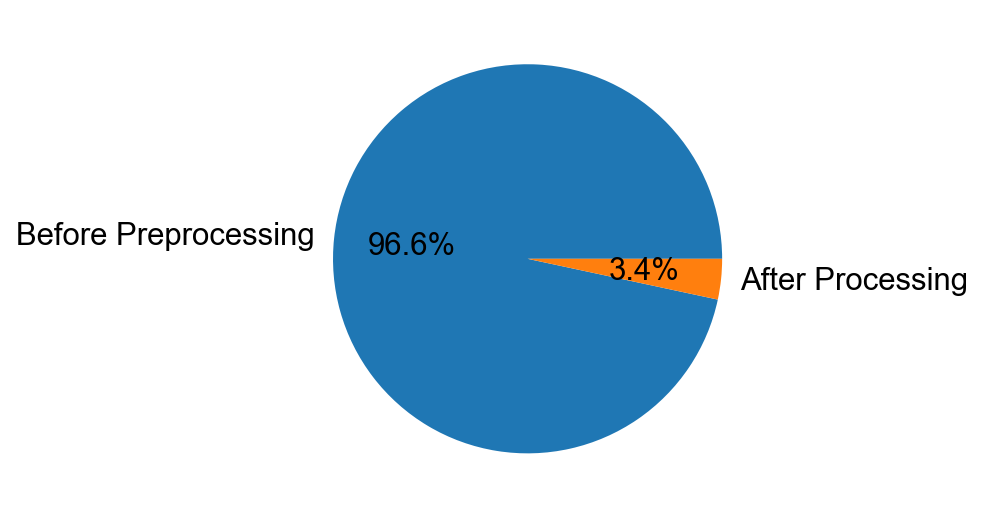

In [55]:
y = np.array([32738, 1139])
mylabels = ["Before Preprocessing", "After Processing "]

plt.pie(y, labels = mylabels, autopct='%1.1f%%')

plt.show() 